# Regression kink design with `pymc` models

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42
rng = np.random.default_rng(seed)

The {term}`Regression kink design` should be analysed by a piecewise continuous function. That is:
* We want a function which can capture the data to the left and to the right of the kink point.
* We want a piecewise function with one breakpoint or kink point
* The function should be continuous at the kink point

An example of such a function would be a piecewise continuous polynomial:

$$
\mu = \beta_0 + \beta_1 \cdot x + \beta_2 \cdot x^2 + \beta_3 \cdot (x-k) \cdot t + \beta_4 \cdot (x-k)^2 \cdot t
$$

Where:
* $\beta$'s are the unknown parameters,
* $x$ is the running variable,
* $t$ is an indicator variable which is $1$ if $x \geq k$, and $0$ otherwise,
* $k$ is the value of $x$ at the kink point.

We can visualise what these functions look like by plotting a number of them with randomly chosen $\beta$ coefficients, but all with a kink point at $0.5$.


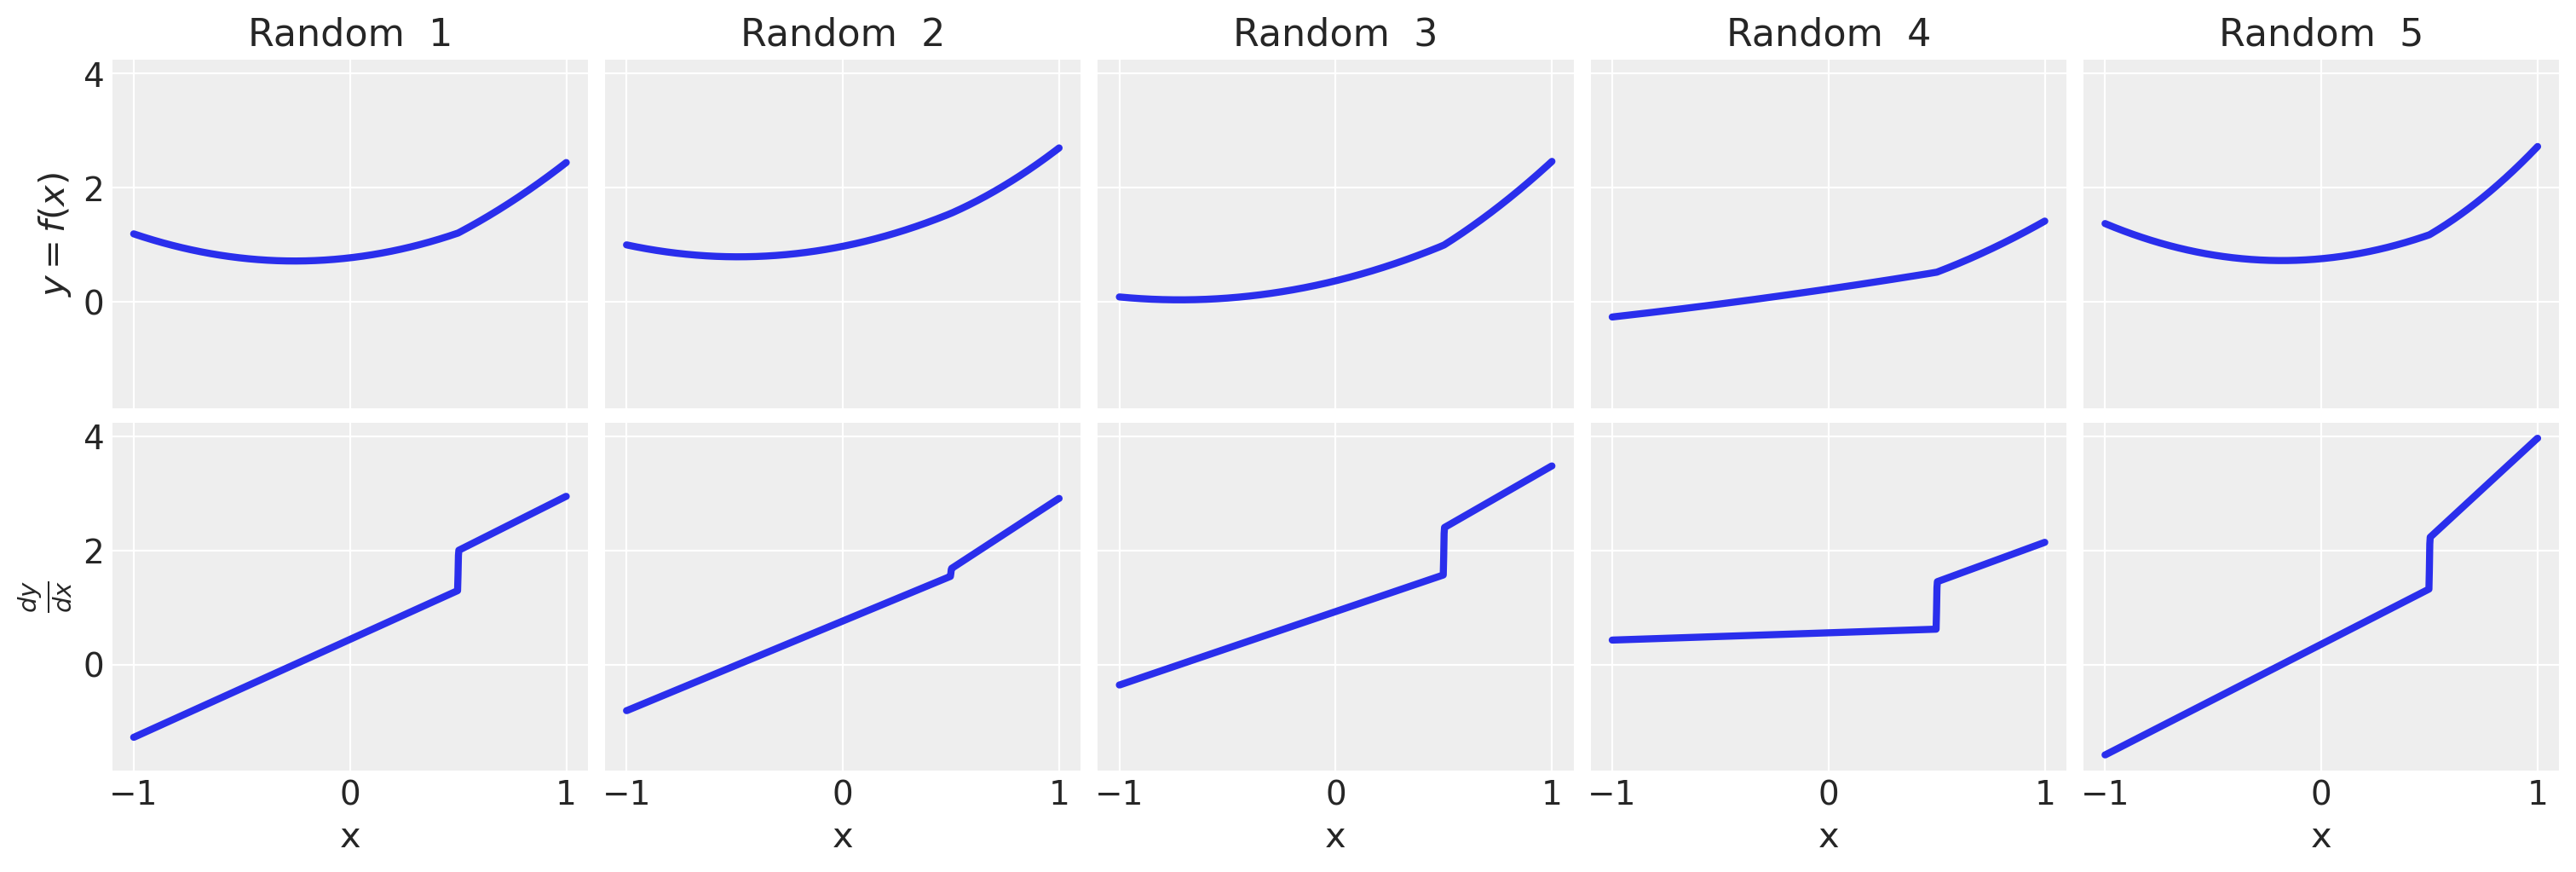

In [3]:
def f(x, beta, kink):
    return (
        beta[0]
        + beta[1] * x
        + beta[2] * x**2
        + beta[3] * (x - kink) * (x >= kink)
        + beta[4] * (x - kink) ** 2 * (x >= kink)
    )


def gradient_change(beta, kink, epsilon=0.01):
    gradient_left = (f(kink, beta, kink) - f(kink - epsilon, beta, kink)) / epsilon
    gradient_right = (f(kink + epsilon, beta, kink) - f(kink, beta, kink)) / epsilon
    gradient_change = gradient_right - gradient_left
    return gradient_change


x = np.linspace(-1, 1, 1000)
kink = 0.5
cols = 5

fig, ax = plt.subplots(2, cols, sharex=True, sharey=True, figsize=(15, 5))

for col in range(cols):
    beta = rng.random(5)
    ax[0, col].plot(x, f(x, beta, kink), lw=3)
    ax[1, col].plot(x, np.gradient(f(x, beta, kink), x), lw=3)
    ax[0, col].set(title=f"Random  {col+1}")
    ax[1, col].set(xlabel="x")

ax[0, 0].set(ylabel="$y = f(x)$")
ax[1, 0].set(ylabel=r"$\frac{dy}{dx}$");

The idea of regression kink analysis is to fit a suitable function to data and to estimate whether there is a change in the gradient of the function at the kink point.

Below we will generate a number of datasets and run through how to conduct the regression kink analysis. We will use a function to generate simulated datasets with the properties we want.

In [4]:
def generate_data(beta, kink, sigma=0.05, N=50):
    if beta is None:
        beta = rng.random(5)
    x = rng.uniform(-1, 1, N)
    y = f(x, beta, kink) + rng.normal(0, sigma, N)
    df = pd.DataFrame({"x": x, "y": y, "treated": x >= kink})
    return df

## Example 1 - continuous piecewise linear function
In this example we'll stick to a simple continuous piecewise function.

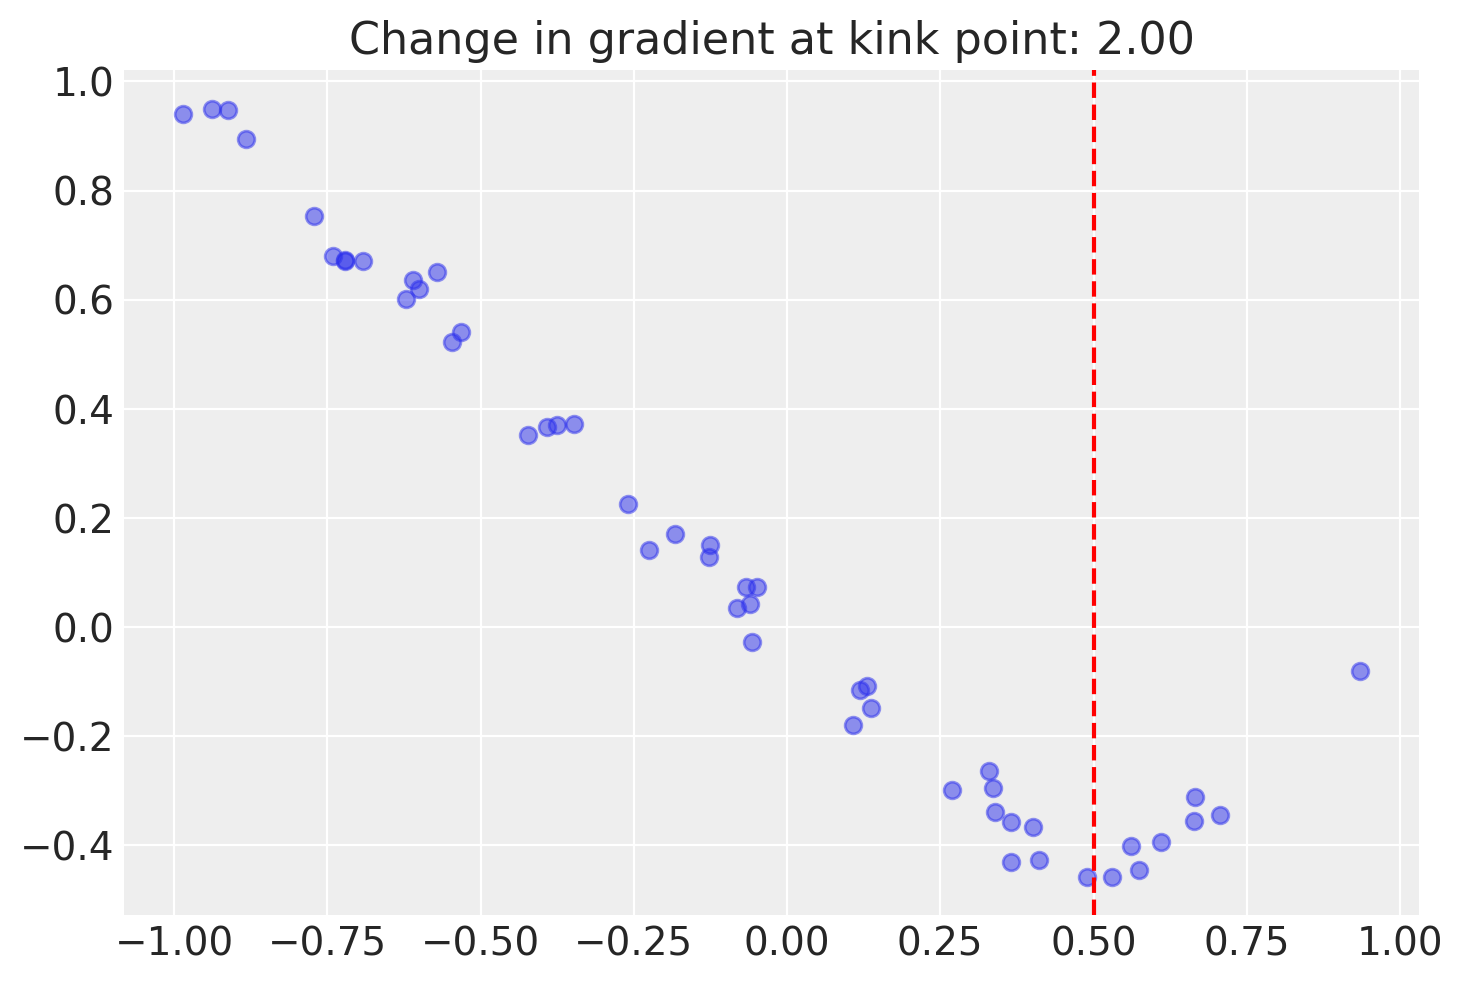

In [5]:
kink = 0.5
# linear function with gradient change of 2 at kink point
beta = [0, -1, 0, 2, 0]
sigma = 0.05
df = generate_data(beta, kink, sigma=sigma)

fig, ax = plt.subplots()
ax.scatter(df["x"], df["y"], alpha=0.5)
ax.axvline(kink, color="red", linestyle="--")
ax.set(title=f"Change in gradient at kink point: {gradient_change(beta, kink):.2f}");

We can use the regular `cp.pymc_models.LinearRegression` model and enforce the continuous piecewise nature by cleverly specifying a design matrix via the `formula` input.

In this example, setting the formula to `"y ~ 1 + x + I((x-0.5)*treated)"` (where the 0.5 is the kink point) equates to the following model:

$$
\mu = \beta_0 + \beta_1 \cdot x + \beta_3 \cdot (x-k) \cdot t
$$

:::{note}
The change in gradient either side of the kink point is evaluated numerically. The `epsilon` parameter determines the distance either side of the kink point that is used in this change in gradient calculation.
:::

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


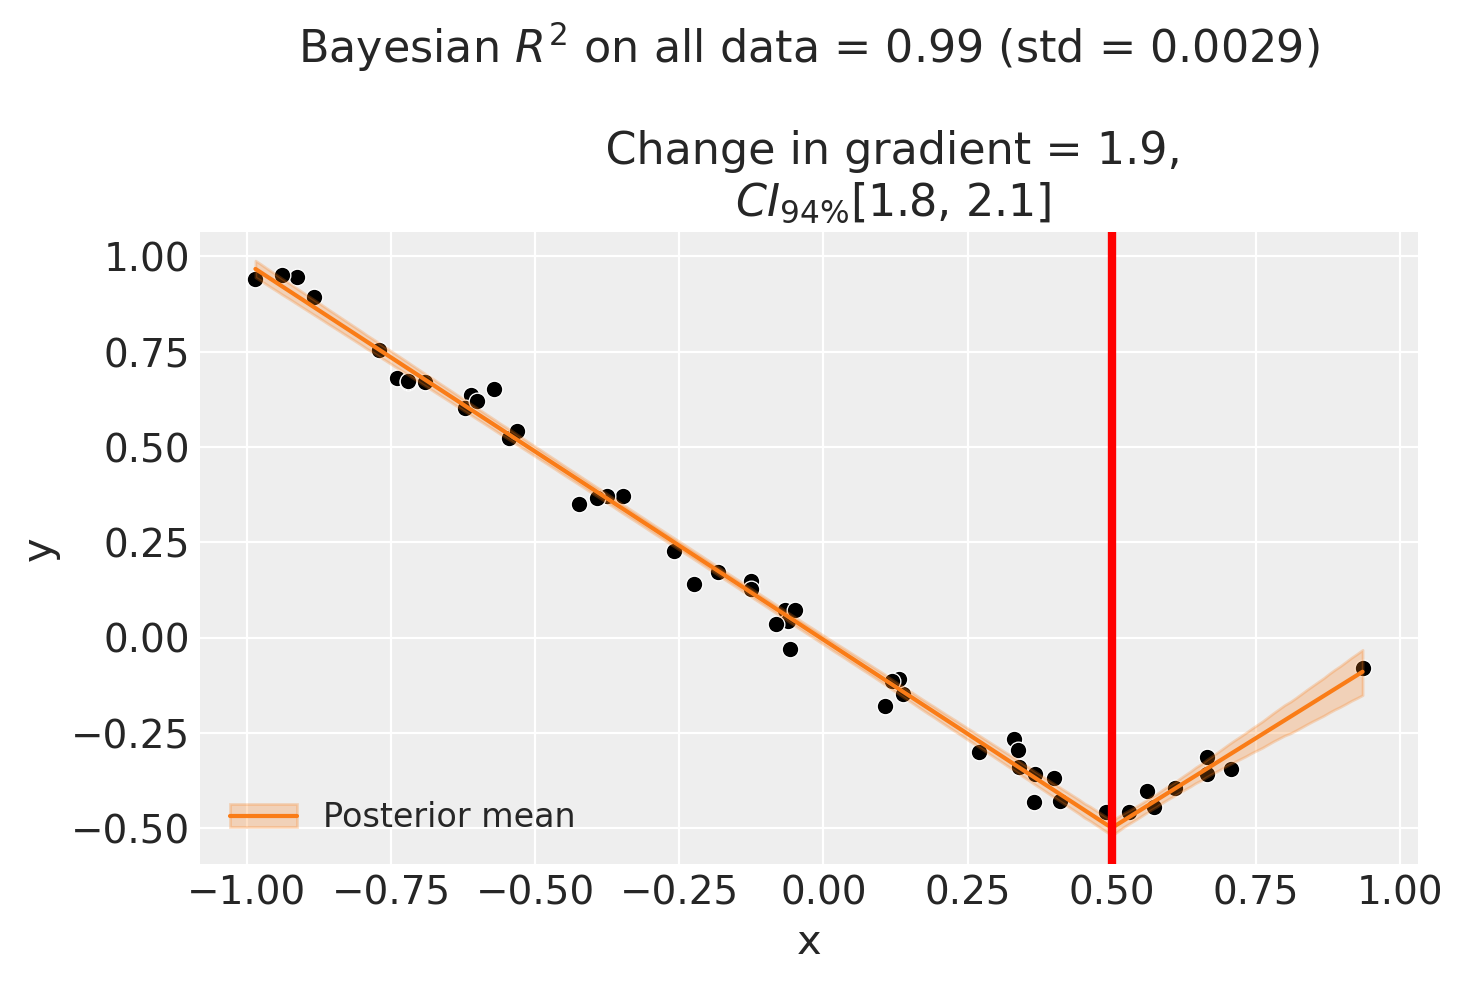

In [6]:
result1 = cp.pymc_experiments.RegressionKink(
    df,
    formula=f"y ~ 1 + x + I((x-{kink})*treated)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    kink_point=kink,
    epsilon=0.1,
)

fig, ax = result1.plot()

If you want to plot the posterior distribution of the inferred gradient change, you can do it as follows.

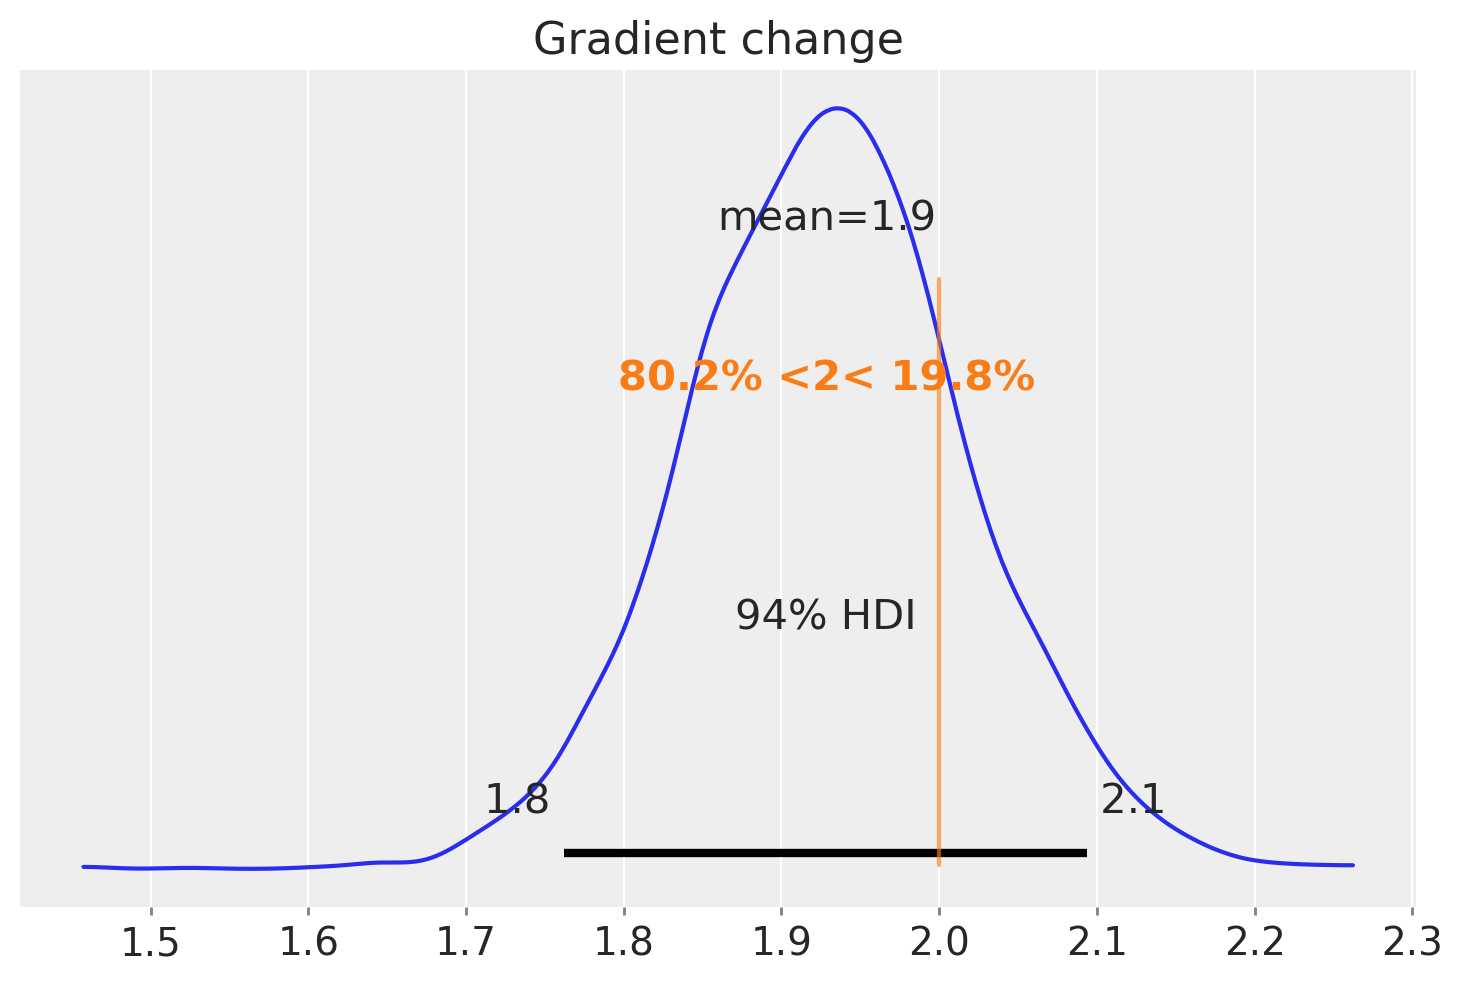

In [7]:
ax = az.plot_posterior(result1.gradient_change, ref_val=gradient_change(beta, kink))
ax.set(title="Gradient change");

We know that the correct gradient change is 2, and that we have correctly recovered it as the posterior distribution is centred around 2.

We can also ask for summary information:

In [8]:
result1.summary()


        ================================Regression Kink=================================
        Formula: y ~ 1 + x + I((x-0.5)*treated)
        Running variable: x
        Kink point on running variable: 0.5

        Results:
        Change in slope at kink point = 1.9
        
Model coefficients:
Intercept                     -0.0055, 94% HDI [-0.017, 0.0065]
x                             -0.99, 94% HDI [-1, -0.96]
I((x - 0.5) * treated)        1.9, 94% HDI [1.8, 2.1]
sigma                         0.039, 94% HDI [0.032, 0.048]


## Example 2 - continuous piecewise polynomial function

Now we'll introduce some nonlinearity into the mix.

In this example, we're going to have a 2nd order polynomial on either side of the kink point. So the model can be defined as:

$$
\mu = \beta_0 + \beta_1 \cdot x + \beta_2 \cdot x^2 + \beta_3 \cdot (x-k) \cdot t + \beta_4 \cdot (x-k)^2 \cdot t
$$

While it's a bit verbose, we can implement this in a [patsy](https://patsy.readthedocs.io/en/latest/index.html) formula as so:

> `y ~ 1 + x + np.power(x, 2) + I((x-0.5)*treated) + I(np.power((x-0.5), 2)*treated)` 

where the 0.5 is the kink point.

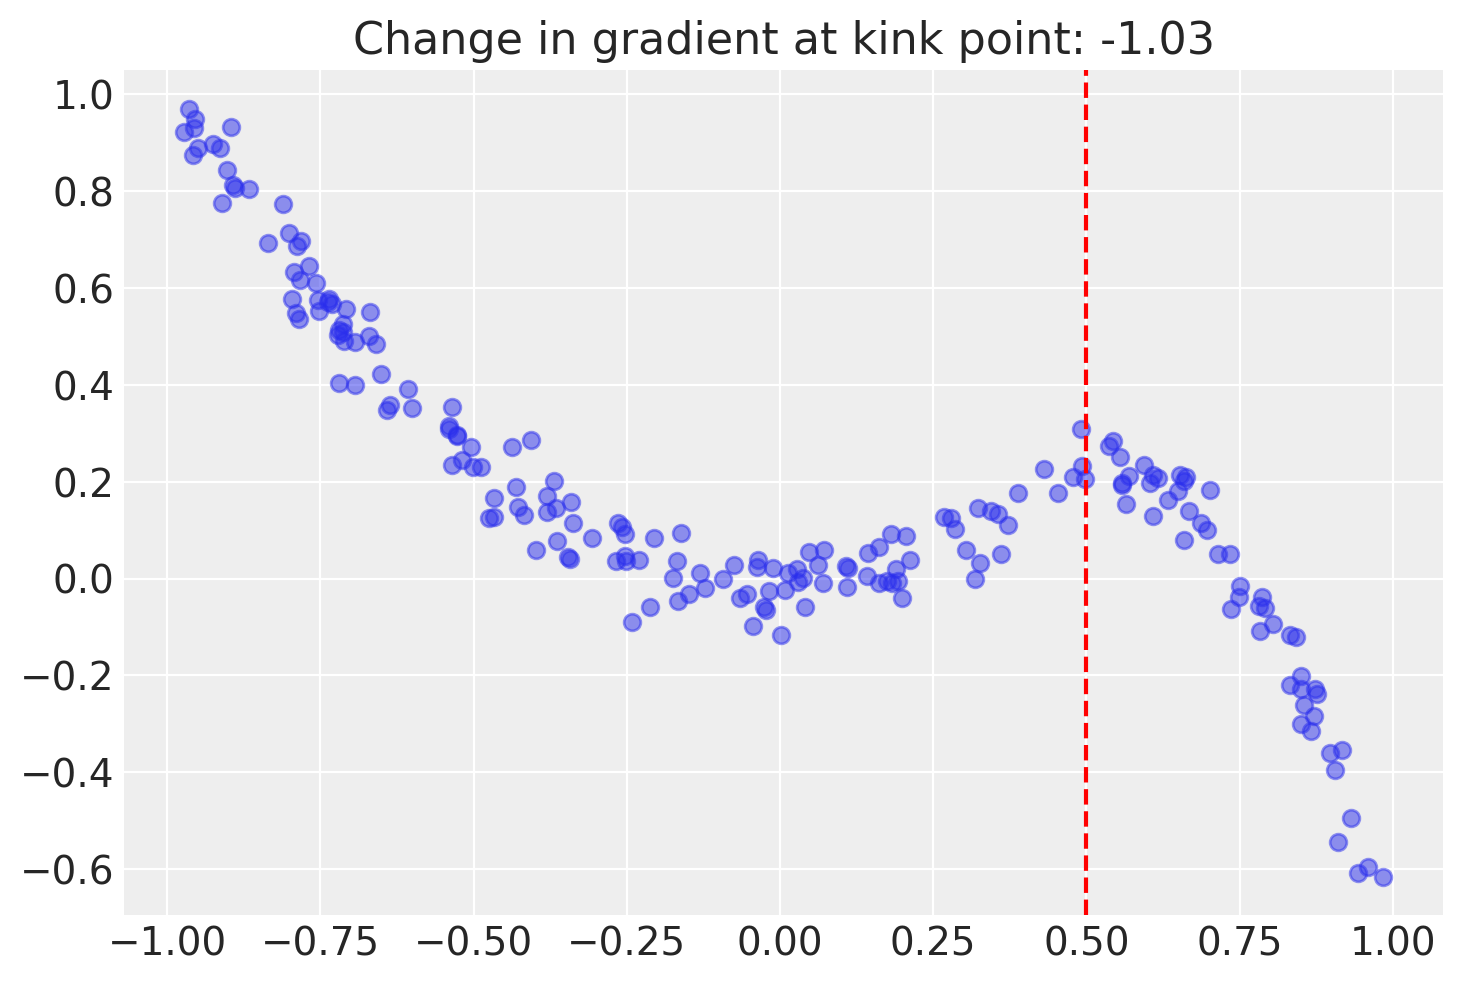

In [9]:
kink = 0.5
# quadratic function going from 1*x^2 on the left of the kink point, to 1*x^2 -
# 1*(x-kink) - 5*(x-kink)^2 to the right of the kink point
beta = [0, 0, 1, -1, -5]
df = generate_data(beta, kink, N=200, sigma=sigma)

fig, ax = plt.subplots()
ax.scatter(df["x"], df["y"], alpha=0.5)
ax.axvline(kink, color="red", linestyle="--")
ax.set(title=f"Change in gradient at kink point: {gradient_change(beta, kink):.2f}");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


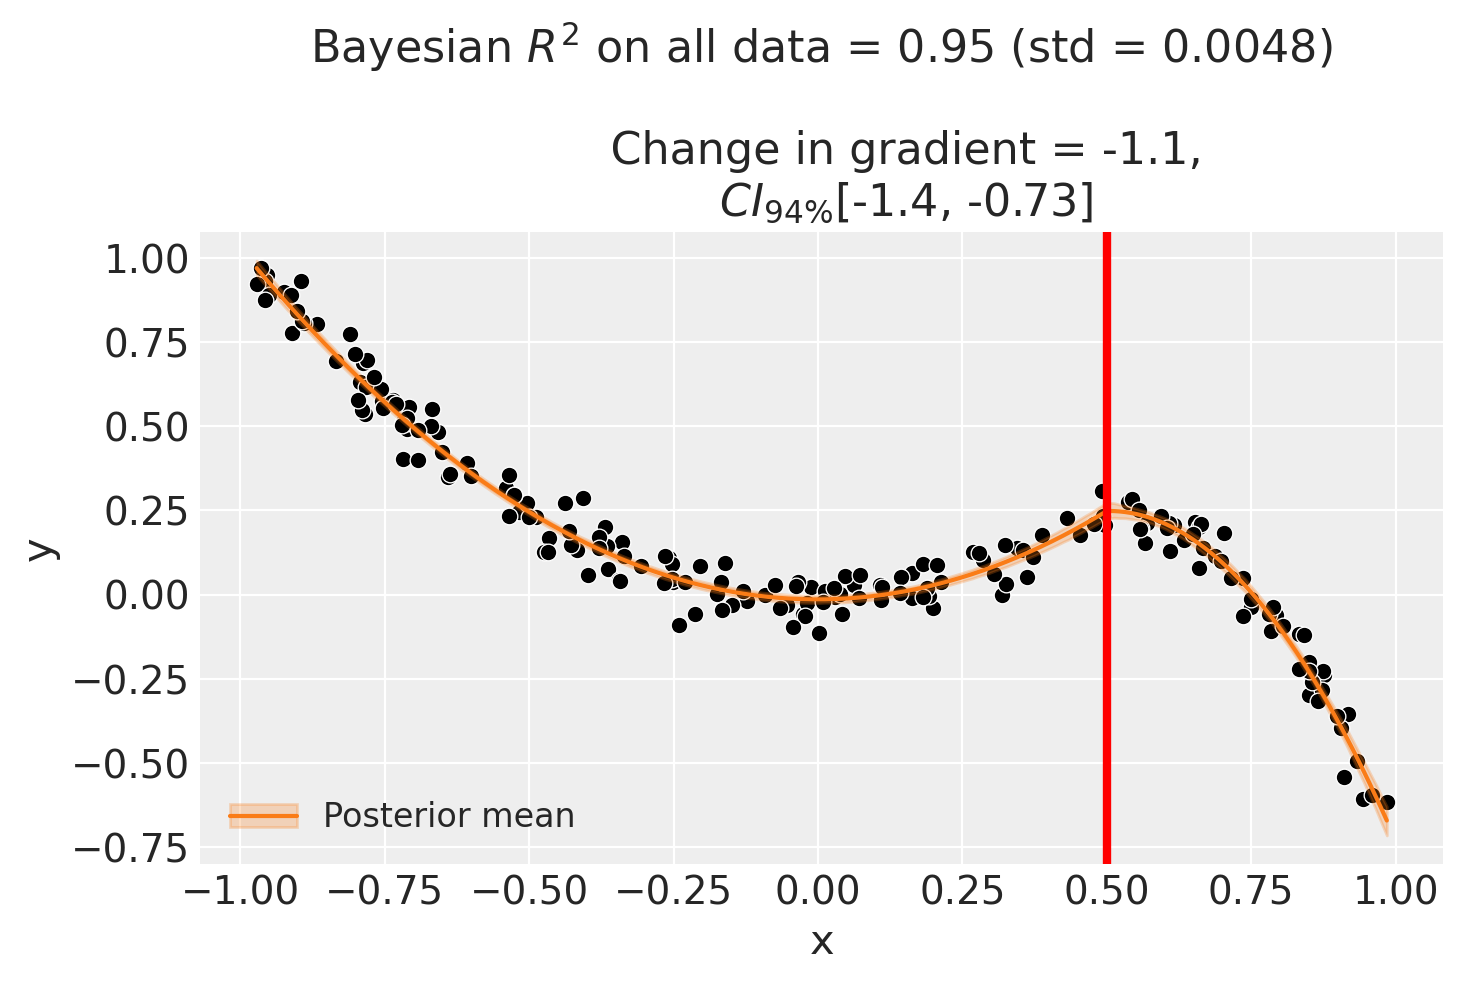

In [10]:
formula = f"y ~ 1 + x + np.power(x, 2) + I((x-{kink})*treated) + I(np.power(x-{kink}, 2)*treated)"

result2 = cp.pymc_experiments.RegressionKink(
    df,
    formula=formula,
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    kink_point=kink,
    epsilon=0.01,
)

fig, ax = result2.plot()

We can also evaluate the posterior distribution of the parameters and see how they match up with the true values.

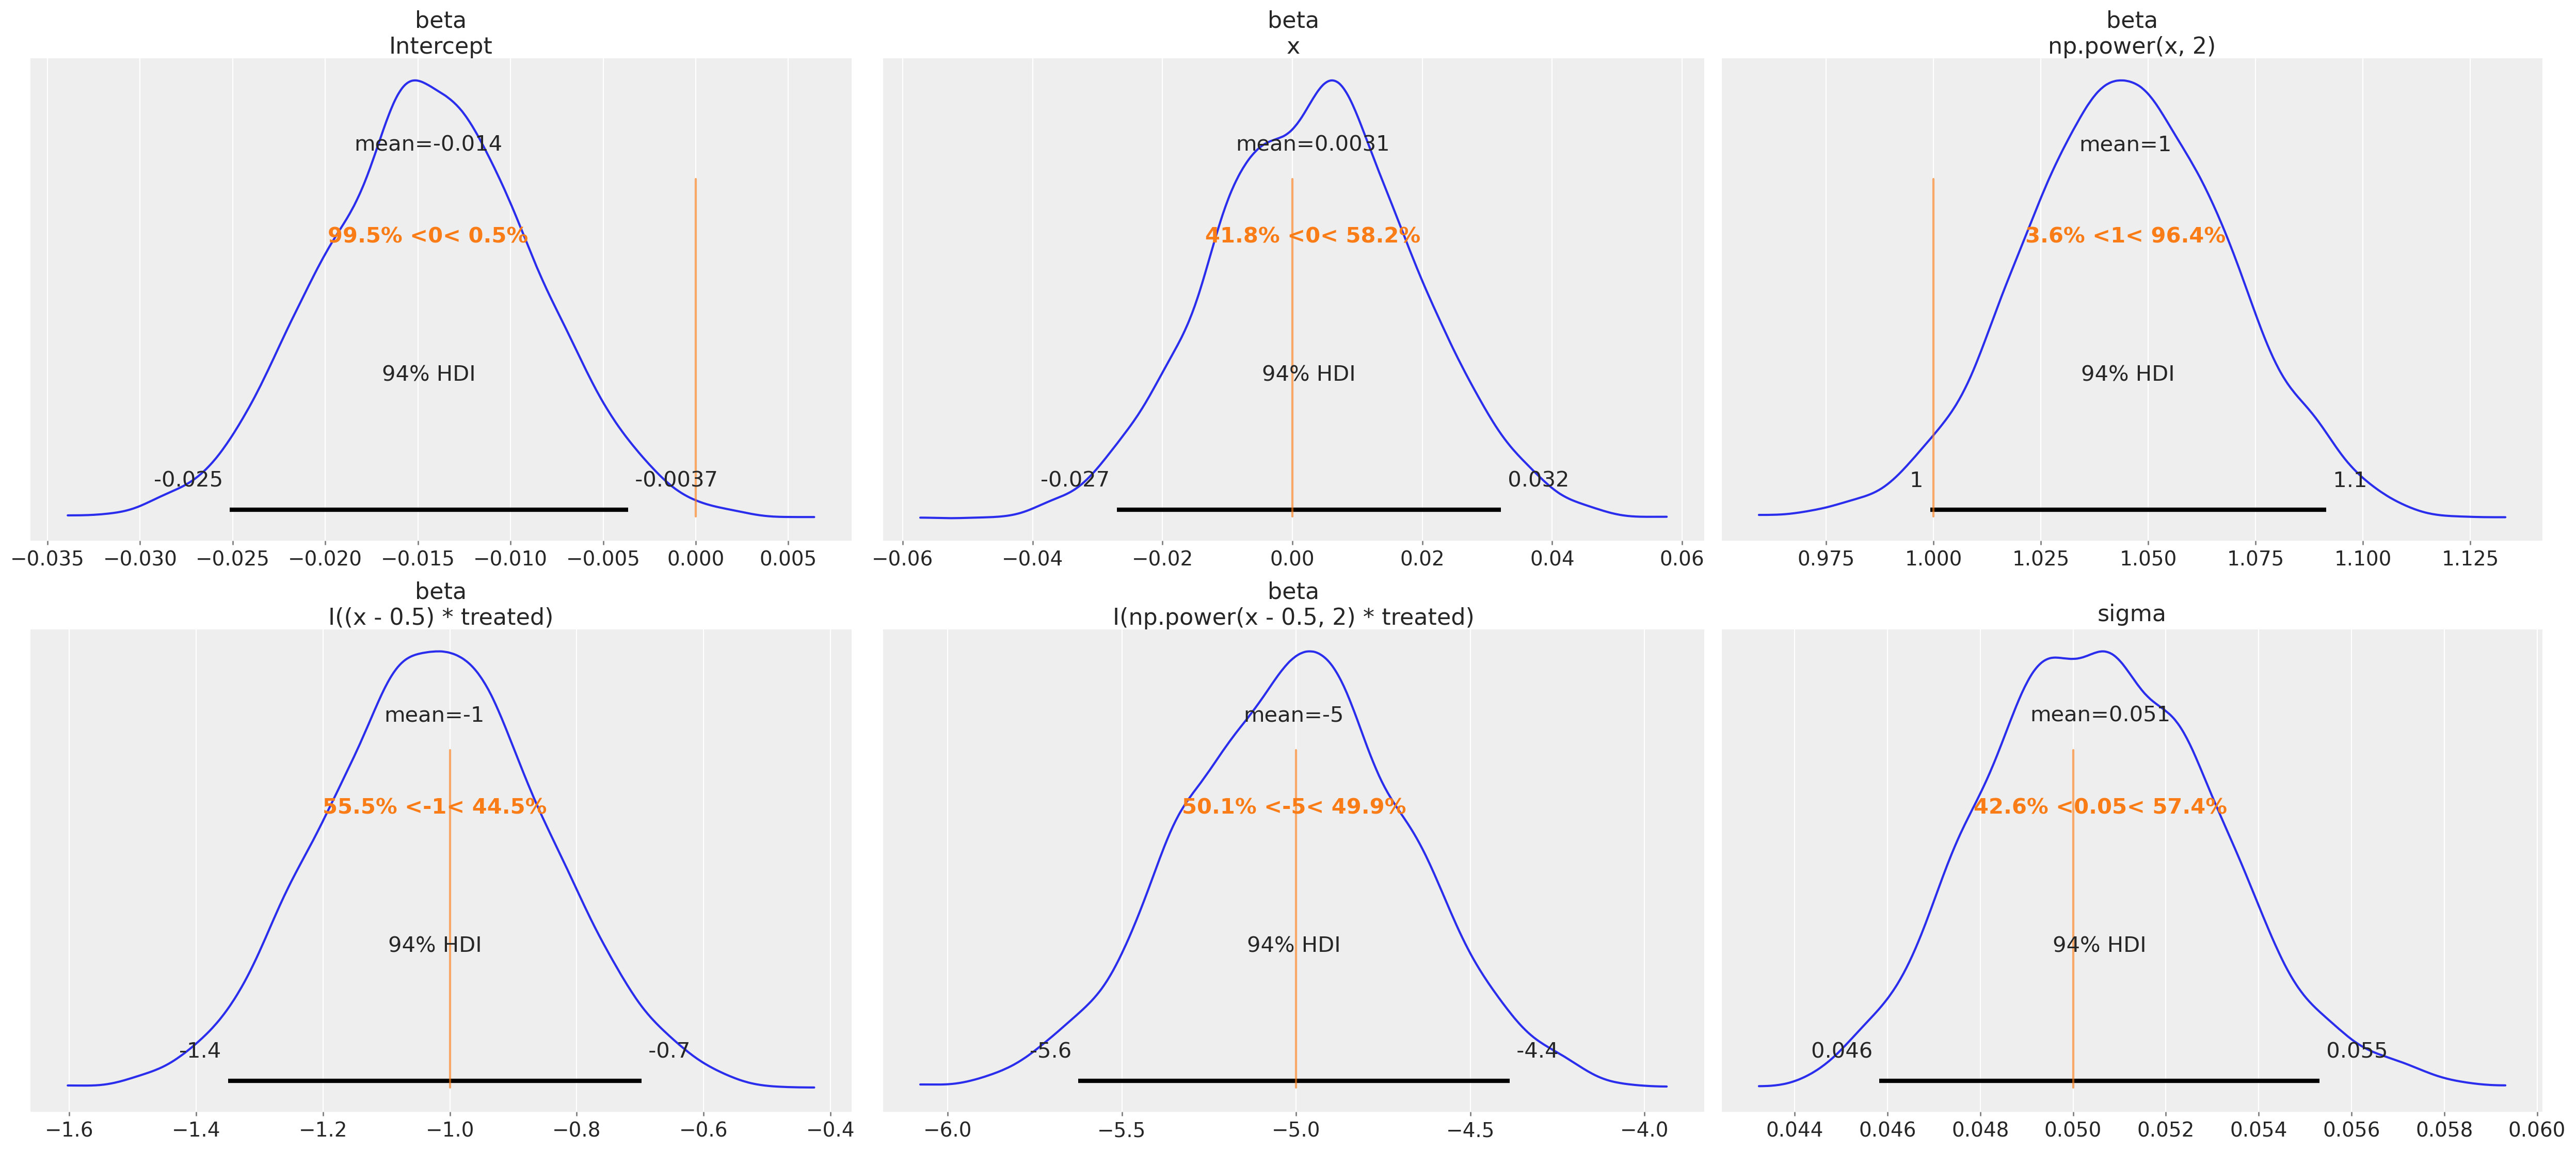

In [11]:
ax = az.plot_posterior(
    result2.idata, var_names=["beta", "sigma"], ref_val=beta + [sigma]
)

Finally, we can see that we have also done a good job at recovering the true gradient change.

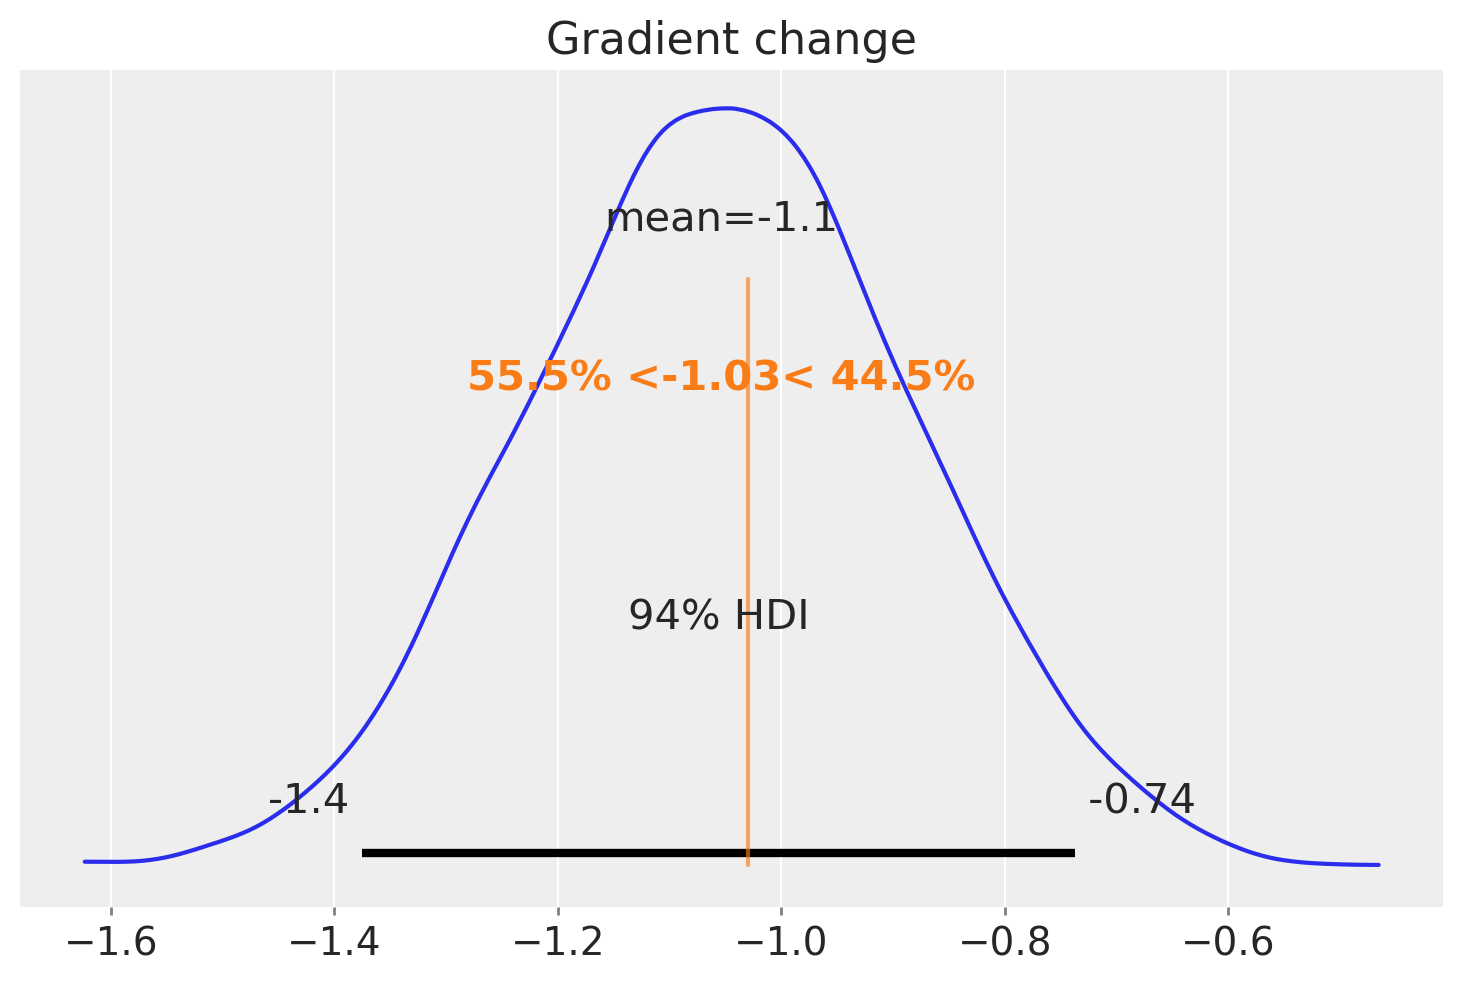

In [12]:
ax = az.plot_posterior(result2.gradient_change, ref_val=gradient_change(beta, kink))
ax.set(title="Gradient change");

## Example 3 - basis spline model

As a final example to demonstrate that we need not be constrained to polynomial functions, we can use a basis spline model. This takes advantage of the capability of `patsy` to generate design matricies with basis splines. Note that we will use the same simulated dataset as the previous example.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


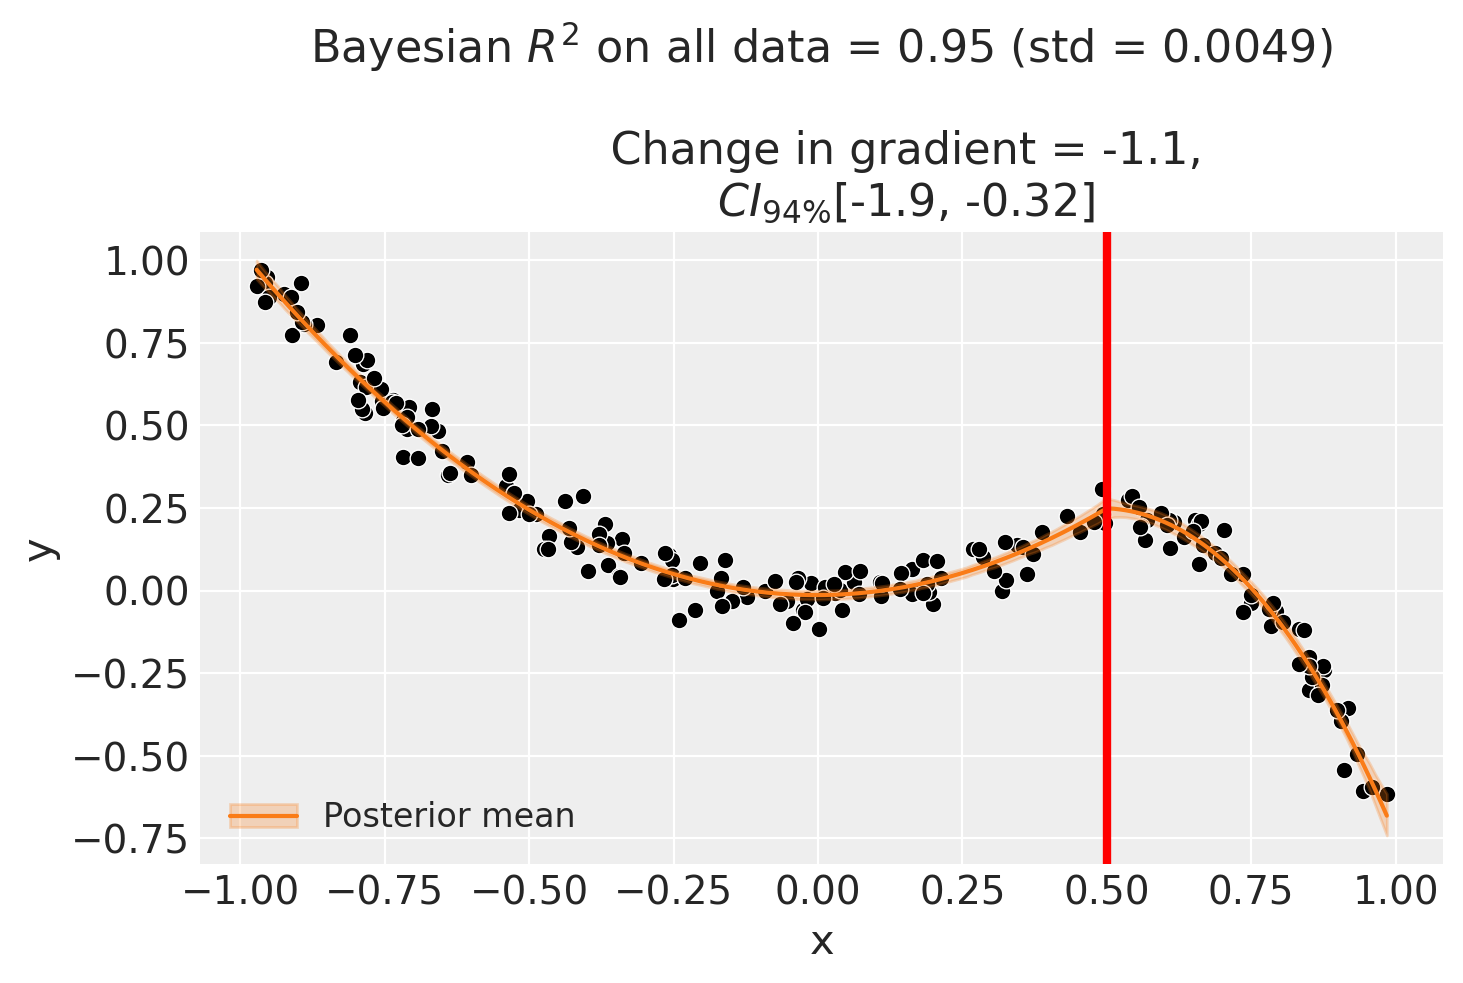

In [13]:
result3 = cp.pymc_experiments.RegressionKink(
    df,
    formula=f"y ~ 1 + bs(x, df=3) + bs(I(x-{kink})*treated, df=3)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    kink_point=kink,
)

result3.plot();

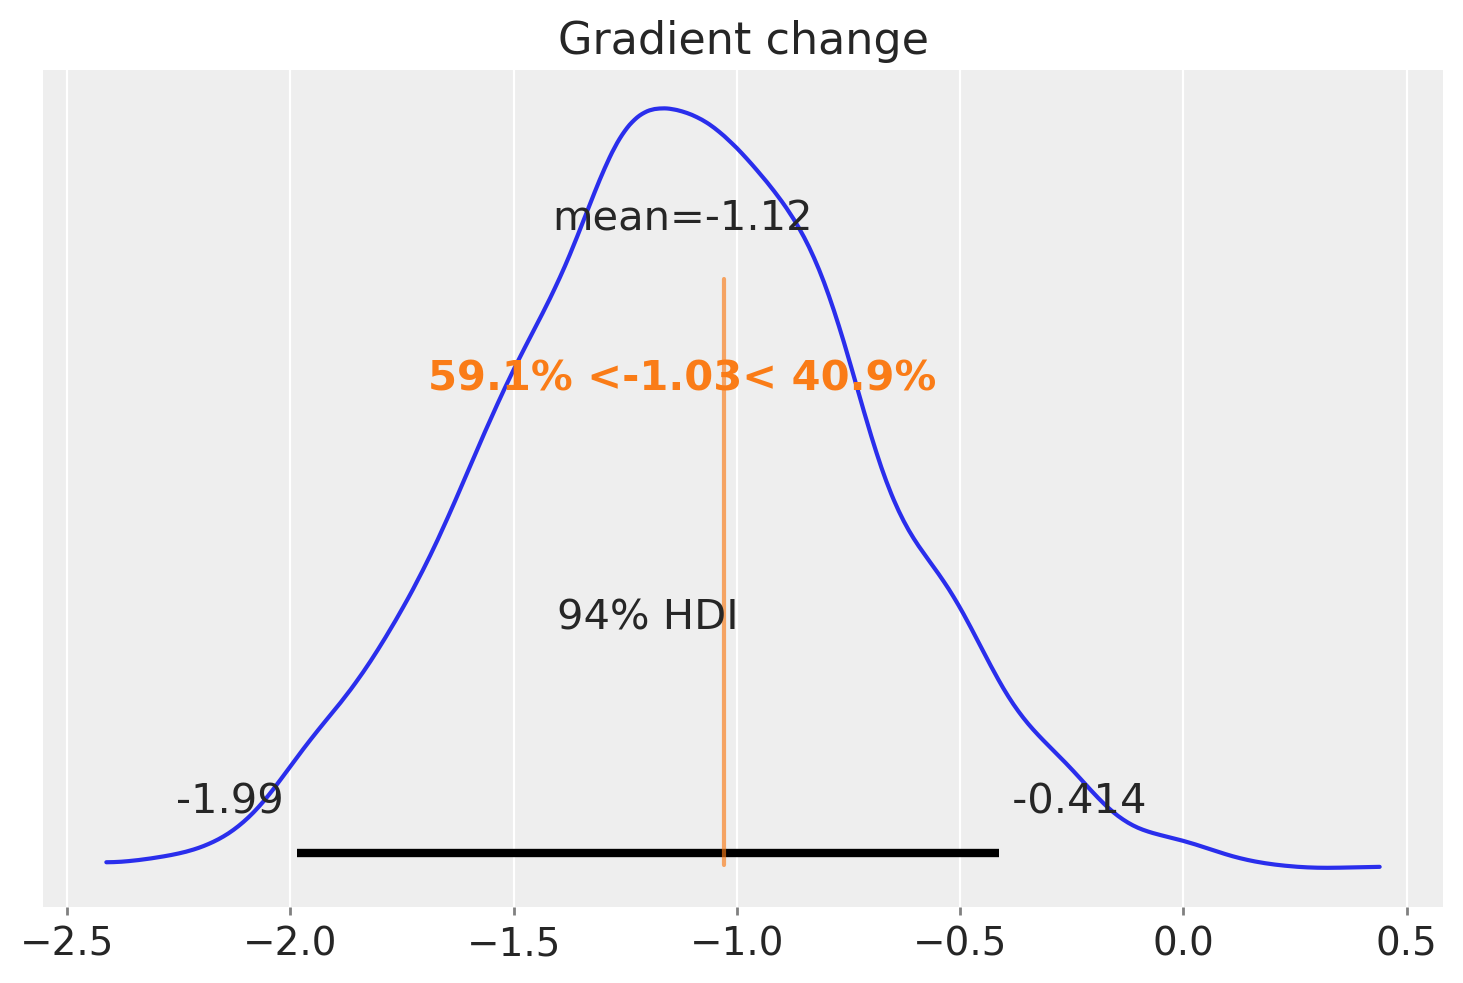

In [14]:
ax = az.plot_posterior(
    result3.gradient_change, ref_val=gradient_change(beta, kink), round_to=3
)
ax.set(title="Gradient change");

## Using a bandwidth

If we don't want to fit on _all_ the data available, we can use the `bandwidth` kwarg. This will only fit the model to data within a certain bandwidth of the kink point. If $x$ is the running variable, then the model will only be fitted to data where $threshold - bandwidth \le x \le threshold + bandwidth$.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


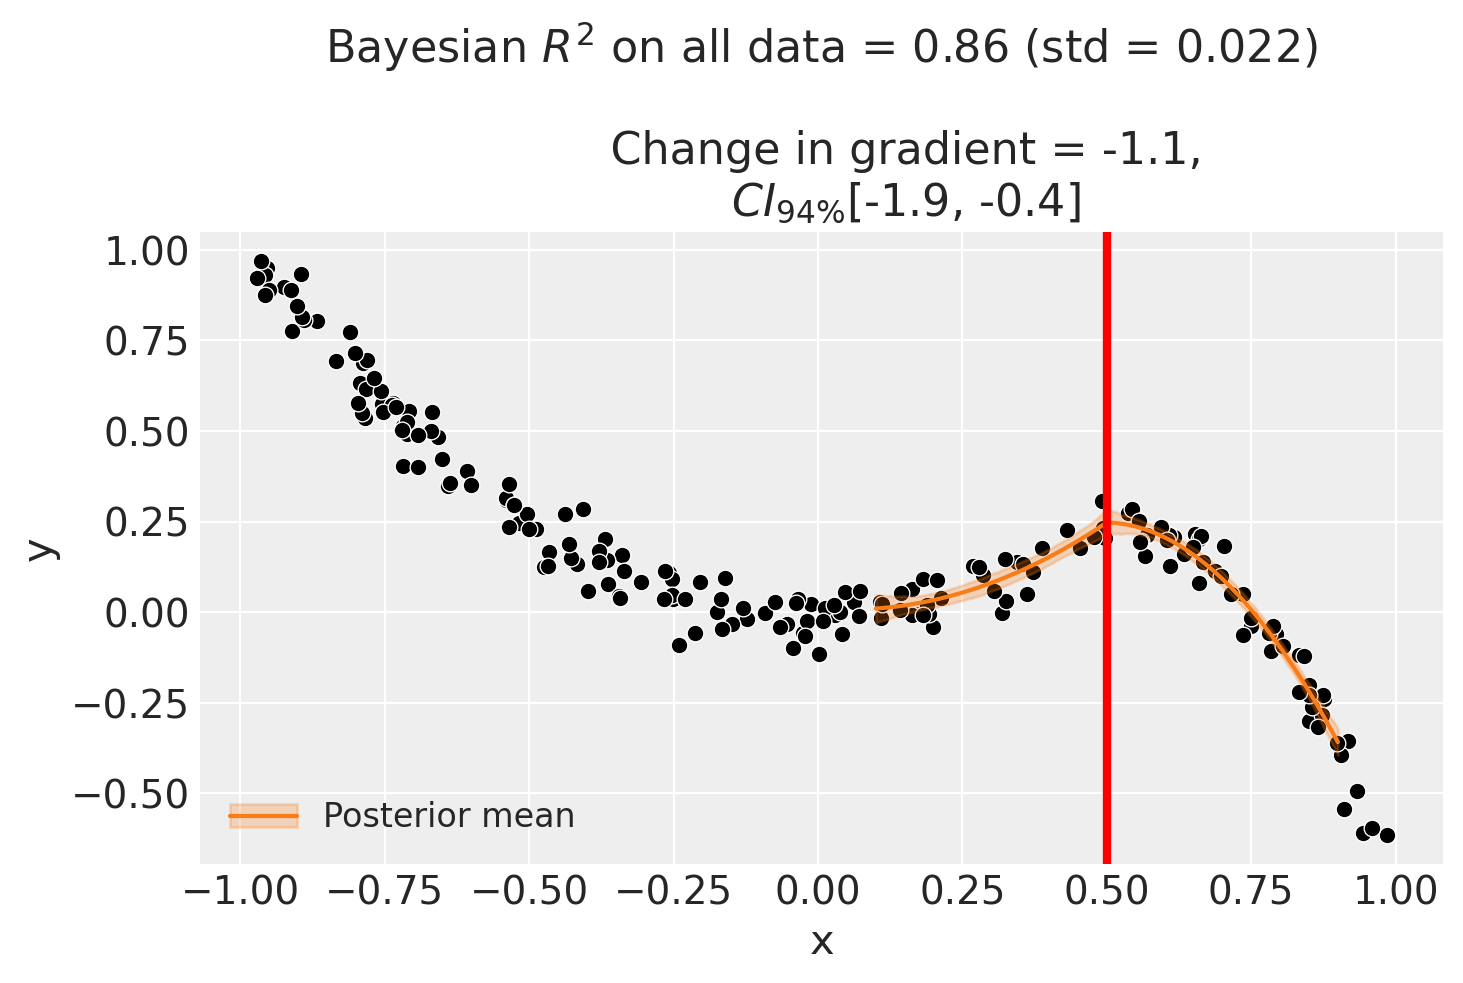

In [15]:
formula = f"y ~ 1 + x + np.power(x, 2) + I((x-{kink})*treated) + I(np.power(x-{kink}, 2)*treated)"

result4 = cp.pymc_experiments.RegressionKink(
    df,
    formula=formula,
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    kink_point=kink,
    epsilon=0.01,
    bandwidth=0.4,
)

fig, ax = result4.plot()

Notice now that the data outside of the bandwidth is ignored in the fit.